In [1]:
import sys
print(sys.version)

import pandas as pd
import numpy as np

import geopandas as gpd
print(f'GeoPandas version:', gpd.__version__)

from shapely.geometry import Point, Polygon # gpd uses this for geometries
import pyproj # gpd uses pyproj for projections
import descartes #gpd using descartes to build areas with polygons

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns 


3.7.7 (default, Mar 23 2020, 17:31:31) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
GeoPandas version: 0.8.1


## Reading the taxi rides dataset to geopandas

The dataset that I'll be using for the mapping datapoint manipulation and analysis requires the dur_to_dist and neighbourhood wise assessment. So picking up the dataframe with additional columns of distance and price that's coming in from 1st jupyter notebook.

Creating separate sets for pickup and dropoff points.


In [2]:
df = pd.read_csv('./data/2_new_features_outliers_removed.csv')

In [3]:
print(df.shape)
df.head()


(1033660, 25)


,Unnamed: 0,index,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,...,duration_hours,duration_min,dur_to_dist_m_hpkm,dur_to_dist_m_spkm,speed_kmph_m,day_name,hour,price,month_name,day
0,0,5853,id2966204,1,2016-05-01 10:37:00,2016-05-01 10:41:00,1,-73.939331,40.805038,-73.939262,...,0.071667,4.300000,6.853751,24673.504523,0.145905,Sunday,10,3.5,May,1
1,1,5888,id3871388,1,2016-06-13 09:46:00,2016-06-13 09:47:00,1,-73.945457,40.751652,-73.945389,...,0.025833,1.550000,2.426875,8736.749553,0.412053,Monday,9,3.5,June,13
2,2,5889,id2922653,1,2016-05-02 11:27:00,2016-05-02 11:36:00,1,-74.017143,40.704968,-74.017075,...,0.139444,8.366667,13.096807,47148.506309,0.076354,Monday,11,3.5,May,2
3,3,5911,id3882784,1,2016-03-21 08:11:00,2016-03-21 08:14:00,1,-73.902061,40.763943,-73.902123,...,0.047500,2.850000,4.657924,16768.526312,0.214688,Monday,8,3.5,March,21
4,4,5922,id3958254,2,2016-04-19 13:59:00,2016-04-19 14:01:00,1,-73.936905,40.764591,-73.936821,...,0.038056,2.283333,3.246898,11688.831597,0.307986,Tuesday,13,3.5,April,19


## Cleaning up the dataframe

In [4]:
df = df.drop(columns=[col for col in df.columns if 'index' in col])

In [5]:
geometry_p = [Point(xy) for xy in zip(df['pickup_longitude'], df['pickup_latitude'])]
geometry_d = [Point(xy) for xy in zip(df['dropoff_longitude'], df['dropoff_latitude'])]
print(geometry_p[:3])
print(geometry_d[:3])

[<shapely.geometry.point.Point object at 0x7fa179a782d0>, <shapely.geometry.point.Point object at 0x7fa179a78390>, <shapely.geometry.point.Point object at 0x7fa179a78650>]
[<shapely.geometry.point.Point object at 0x7fa18e94df10>, <shapely.geometry.point.Point object at 0x7fa18e94dfd0>, <shapely.geometry.point.Point object at 0x7fa18e951050>]


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1033660 entries, 0 to 1033659
Data columns (total 24 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Unnamed: 0          1033660 non-null  int64  
 1   id                  1033660 non-null  object 
 2   vendor_id           1033660 non-null  int64  
 3   pickup_datetime     1033660 non-null  object 
 4   dropoff_datetime    1033660 non-null  object 
 5   passenger_count     1033660 non-null  int64  
 6   pickup_longitude    1033660 non-null  float64
 7   pickup_latitude     1033660 non-null  float64
 8   dropoff_longitude   1033660 non-null  float64
 9   dropoff_latitude    1033660 non-null  float64
 10  store_and_fwd_flag  1033660 non-null  bool   
 11  duration            1033660 non-null  int64  
 12  distance            1033660 non-null  float64
 13  manhattan_dist      1033660 non-null  float64
 14  duration_hours      1033660 non-null  float64
 15  duration_min   

## Creating two geodf's for pickup and dropoff points

In [7]:
crs ='epsg:4326'

In [8]:
#converting the dataframe to a geopandasdataframe for pickup points
geo_df_p = gpd.GeoDataFrame(df, crs = crs, geometry = geometry_p)
print(geo_df_p.head())

   Unnamed: 0         id  vendor_id      pickup_datetime     dropoff_datetime  \
0           0  id2966204          1  2016-05-01 10:37:00  2016-05-01 10:41:00   
1           1  id3871388          1  2016-06-13 09:46:00  2016-06-13 09:47:00   
2           2  id2922653          1  2016-05-02 11:27:00  2016-05-02 11:36:00   
3           3  id3882784          1  2016-03-21 08:11:00  2016-03-21 08:14:00   
4           4  id3958254          2  2016-04-19 13:59:00  2016-04-19 14:01:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.939331        40.805038         -73.939262   
1                1        -73.945457        40.751652         -73.945389   
2                1        -74.017143        40.704968         -74.017075   
3                1        -73.902061        40.763943         -73.902123   
4                1        -73.936905        40.764591         -73.936821   

   dropoff_latitude  ...  duration_min  dur_to_dist_m_hp

In [9]:
#converting the dataframe to a geopandasdataframe for dropoff points
geo_df_d = gpd.GeoDataFrame(df, crs = crs, geometry = geometry_d)
print(geo_df_d.head())


   Unnamed: 0         id  vendor_id      pickup_datetime     dropoff_datetime  \
0           0  id2966204          1  2016-05-01 10:37:00  2016-05-01 10:41:00   
1           1  id3871388          1  2016-06-13 09:46:00  2016-06-13 09:47:00   
2           2  id2922653          1  2016-05-02 11:27:00  2016-05-02 11:36:00   
3           3  id3882784          1  2016-03-21 08:11:00  2016-03-21 08:14:00   
4           4  id3958254          2  2016-04-19 13:59:00  2016-04-19 14:01:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.939331        40.805038         -73.939262   
1                1        -73.945457        40.751652         -73.945389   
2                1        -74.017143        40.704968         -74.017075   
3                1        -73.902061        40.763943         -73.902123   
4                1        -73.936905        40.764591         -73.936821   

   dropoff_latitude  ...  duration_min  dur_to_dist_m_hp

## Geoplotting the pincode map of NYC with geopandas

Reference link: https://geodata.lib.berkeley.edu/catalog/nyu-2451-34509

In [10]:
pincodes = gpd.read_file('./nyu-zipcode file/nyu_2451_34509.shp')

In [11]:
# getting a read on the data

print(pincodes.shape)
print(pincodes.head())
print(type(pincodes))

(214, 4)
    zcta  bcode  note                                           geometry
0  10001  36061  None  POLYGON ((-74.00368 40.74835, -74.00653 40.749...
1  10002  36061  None  POLYGON ((-73.99695 40.71207, -73.99712 40.712...
2  10003  36061  None  POLYGON ((-73.99206 40.72564, -73.99179 40.726...
3  10007  36061  None  POLYGON ((-74.01046 40.71153, -74.01015 40.712...
4  10009  36061  None  POLYGON ((-73.97521 40.71924, -73.97512 40.719...
<class 'geopandas.geodataframe.GeoDataFrame'>


We have **214 zipcodes** in the shapefile and this should help us plot out the stats for pickup and drop off points separately.

In [12]:
# verifying to check if the coordinate reference system corresponds to the lat long geometries
pincodes = pincodes.drop(columns=[col for col in pincodes.columns if 'note' in col])

print(pincodes.crs)

epsg:4326


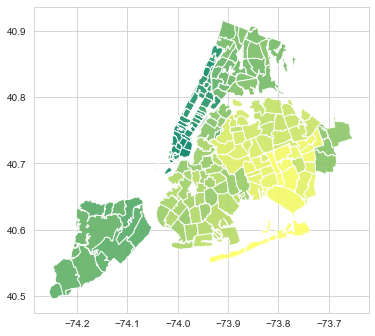

In [13]:
# plotting the pincode area map 

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(6,6), edgecolor='white',linewidth=3)
pincodes.plot(ax=ax,  alpha = 0.9, cmap='summer')
pincodes.to_csv('./data/pincodes.csv')

# Spatial join 

Next step, we will perform a spatial join first on `geo_df` the taxi-geo dataset to that of the `pincodes` geodataframe and map out the location of `pickup points` and `dropoff points` separately - based on the zipcodes and the boro-codes information.


## Spatial join - Pickup coordinates

In [14]:
joined_p = gpd.sjoin(geo_df_p, pincodes, how='left', op='within')

print(joined_p.head())

   Unnamed: 0         id  vendor_id      pickup_datetime     dropoff_datetime  \
0           0  id2966204          1  2016-05-01 10:37:00  2016-05-01 10:41:00   
1           1  id3871388          1  2016-06-13 09:46:00  2016-06-13 09:47:00   
2           2  id2922653          1  2016-05-02 11:27:00  2016-05-02 11:36:00   
3           3  id3882784          1  2016-03-21 08:11:00  2016-03-21 08:14:00   
4           4  id3958254          2  2016-04-19 13:59:00  2016-04-19 14:01:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.939331        40.805038         -73.939262   
1                1        -73.945457        40.751652         -73.945389   
2                1        -74.017143        40.704968         -74.017075   
3                1        -73.902061        40.763943         -73.902123   
4                1        -73.936905        40.764591         -73.936821   

   dropoff_latitude  ...  speed_kmph_m  day_name  hour  

In this view note that there are some NaN values. Most likely they correspond 
to the 'points' that lie outside of the polygon geometries. 

Lets verify this and separate the dataset into 2 sets

1. Rows that fall **'within'** the boundaries. 
2. Rows that all **'outside'** the boundaries.


In [15]:
# picking the not null or `inliers` for further analysis

print(joined_p[joined_p.zcta.notnull()].shape)
joined_innyc_p = joined_p[joined_p.zcta.notnull()]

# picking the null dataset or `outliers `for further analysis.

print(joined_p[joined_p.zcta.isnull()].shape)
joined_outnyc_p = joined_p[joined_p.zcta.isnull()]


(1018105, 28)
(15555, 28)


In [16]:
#saving the dataframe for further analysis later

joined_innyc_p.to_csv('./data/joined_innyc_p.csv')
joined_outnyc_p.to_csv('./data/joined_outnyc_p.csv')

**Approx ~ 15,555 pickup observations** fall outside of the NYC borough boundary region.


## Spatial join - Dropoff coordinates

In [17]:
joined_d = gpd.sjoin(geo_df_d, pincodes, how='left', op='within')
print(joined_d.head())
print()

   Unnamed: 0         id  vendor_id      pickup_datetime     dropoff_datetime  \
0           0  id2966204          1  2016-05-01 10:37:00  2016-05-01 10:41:00   
1           1  id3871388          1  2016-06-13 09:46:00  2016-06-13 09:47:00   
2           2  id2922653          1  2016-05-02 11:27:00  2016-05-02 11:36:00   
3           3  id3882784          1  2016-03-21 08:11:00  2016-03-21 08:14:00   
4           4  id3958254          2  2016-04-19 13:59:00  2016-04-19 14:01:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.939331        40.805038         -73.939262   
1                1        -73.945457        40.751652         -73.945389   
2                1        -74.017143        40.704968         -74.017075   
3                1        -73.902061        40.763943         -73.902123   
4                1        -73.936905        40.764591         -73.936821   

   dropoff_latitude  ...  speed_kmph_m  day_name  hour  

In [18]:
# picking the not null or `inliers` for further analysis

print(joined_d[joined_d.zcta.notnull()].shape)
joined_innyc_d = joined_d[joined_d.zcta.notnull()]

# picking the null dataset or `outliers `for further analysis.

print(joined_d[joined_d.zcta.isnull()].shape)
joined_outnyc_d = joined_d[joined_d.zcta.isnull()]


(1016976, 28)
(16684, 28)


**Approx ~ 16,684 drop off observations** fall outside of the NYC borough boundary region.

In this view note that there are some NaN values. Most likely they correspond 
to the 'points' that lie outside of the polygon geometries. 

Lets verify this and separate the dataset into 2 sets

1. Rows that fall **'within'** the boundaries. 
2. Rows that all **'outside'** the boundaries.


In [19]:
#saving the dataframe for further analysis later

joined_innyc_d.to_csv('./data/joined_innyc_d.csv')
joined_outnyc_d.to_csv('./data/joined_outnyc_d.csv')

## Geographical Mapping - Pickup Coordinates

### Q1. Which neighborhoods/zip codes tends to experience a relatively higher density of pick-ups? 

### Q3. Which neighborhoods/zip codes tends to have the highest duration-to-distance ratios, based on pick-up?

In [20]:
# Setting the index of pincodes to `zcta` 
# Grouping the data by zipcode and rounding up the count/value of pickup's/dur_to_dist helps us answer teh above q's

pincodes.set_index('zcta',inplace=True)

In [51]:
#creating new featurse to capture the 1. count of pickups for each zipcode location. 
# 2. dur_to_dist in seconds for each zipcode location

pincodes['zcta_count_p'] = joined_p['zcta'].value_counts()
pincodes['dur_to_dist_median_p'] = joined_p.groupby('zcta')['dur_to_dist_m_spkm'].agg('median').round(2)


In [52]:
print(pincodes.shape)
print(pincodes.head())
print(pincodes.info())

(214, 6)
       bcode                                           geometry  zcta_count_p  \
zcta                                                                            
10001  36061  POLYGON ((-74.00368 40.74835, -74.00653 40.749...       51719.0   
10002  36061  POLYGON ((-73.99695 40.71207, -73.99712 40.712...       19332.0   
10003  36061  POLYGON ((-73.99206 40.72564, -73.99179 40.726...       54031.0   
10007  36061  POLYGON ((-74.01046 40.71153, -74.01015 40.712...        8150.0   
10009  36061  POLYGON ((-73.97521 40.71924, -73.97512 40.719...       19677.0   

       dur_to_dist_median_p  zcta_count_d  dur_to_dist_mean_d  
zcta                                                           
10001                247.88       51840.0          270.466437  
10002                210.63       17823.0          267.973616  
10003                241.62       44584.0          241.144023  
10007                210.82        6734.0          212.663510  
10009                225.76       19289

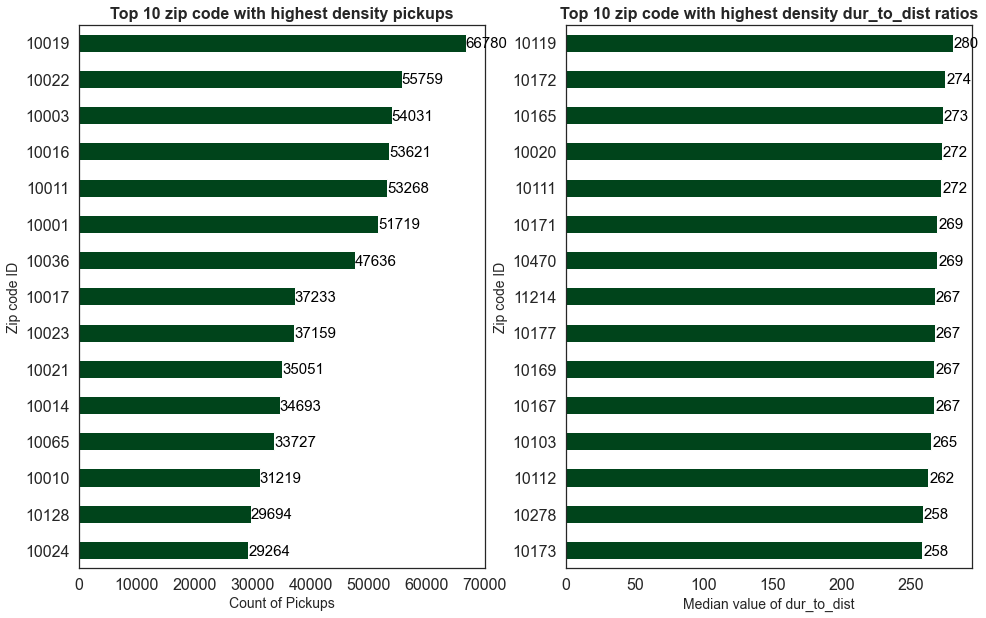

In [113]:
from matplotlib import style
#styles
sns.set_theme(style="white")

## plotting in subplots. 

fig = plt.figure(figsize=(16,10))

ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

# mapping top 10 zipcodes that have highest pickup numbers


t15_p = joined_p['zcta'].value_counts().sort_values(ascending=False).head(15)
t15_p.plot.barh(ax=ax1, fontsize=16,cmap='Greens_r')
# t15_p.apply(lambda y: ax.annotate(text=y.zcta_count_p, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

ax1.set_xlabel('Count of Pickups', fontsize=14)
ax1.set_ylabel('Zip code ID', fontsize=14,)
ax1.set_title('Top 10 zip code with highest density pickups', fontsize=16, weight='bold') 
ax1.invert_yaxis()


# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax1.patches:
    totals.append(i.get_width())

# set individual bar labels using above list
for i in ax1.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax1.text(i.get_width()+0.9, i.get_y()+.38, str(round(i.get_width())), fontsize=15, color='black')
    


# mapping top 10 zipcodes that have highest dur_to_dist ratios


t15_dd_p = joined_p.groupby('zcta')['dur_to_dist_m_spkm'].agg('median').sort_values(ascending=False).head(15).round(2)
t15_dd_p.plot.barh(ax=ax2, fontsize=16, cmap='Greens_r')
ax2.set_xlabel('Median value of dur_to_dist', fontsize=14)
ax2.set_ylabel('Zip code ID', fontsize=14,)
ax2.set_title('Top 10 zip code with highest density dur_to_dist ratios', fontsize=16, weight='bold')
ax2.invert_yaxis()

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax2.patches:
    totals.append(i.get_width())

# # set individual bar labels using above list
# total = sum(totals)

# set individual bar labels using above list
for i in ax2.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax2.text(i.get_width()+0.9, i.get_y()+.38, str(round(i.get_width())), fontsize=15, color='black')



<AxesSubplot:>

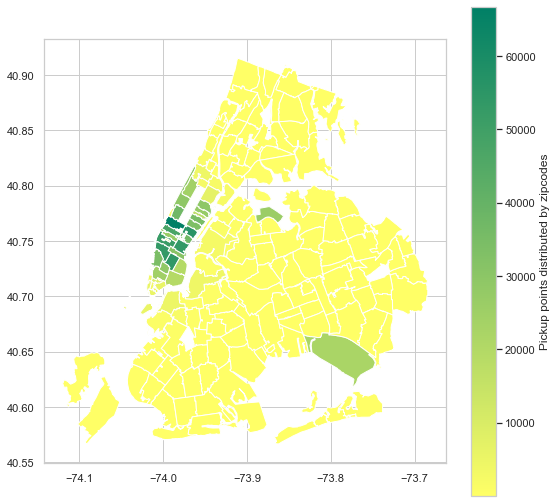

In [84]:
# fig, ax = plt.subplots(1, 1)


fig, ax = plt.subplots(figsize=(9,9), edgecolor='white',linewidth=4)

pincodes.plot(column='zcta_count_p', 
            ax=ax,
            cmap = 'summer_r',  
            legend=True, 
            legend_kwds={'label': "Pickup points distributed by zipcodes"})

<AxesSubplot:>

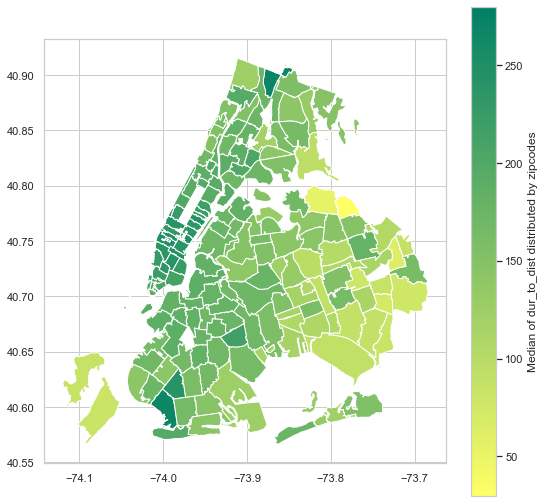

In [25]:
# fig, ax = plt.subplots(1, 1)

fig, ax = plt.subplots(figsize=(9,9), edgecolor='white',linewidth=4)

#label each zipcode with dur_to_dist_p
# pincodes.apply(lambda x: ax.annotate(text=x.dur_to_dist_median_p, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)


pincodes.plot(column='dur_to_dist_median_p', 
            ax=ax,
            cmap = 'summer_r',  
            legend=True, 
            legend_kwds={'label': "Median of dur_to_dist distributed by zipcodes"})

### Mapping Manhattan borough - Pickup

In [55]:
# quering the dataset by limiting the output to 'Manhattan' alone with borough code = 36061.

pincodes_manhattan = pincodes.query('bcode == "36061"').sort_values(by='zcta_count_p',ascending=False)
pincodes_manhattan.head(12)


,bcode,geometry,zcta_count_p,dur_to_dist_median_p,zcta_count_d,dur_to_dist_mean_d
zcta,,,,,,
10019,36061,"POLYGON ((-73.99270 40.76343, -73.99336 40.763...",66780.0,240.53,60436.0,256.380954
10022,36061,"POLYGON ((-73.96934 40.76355, -73.96773 40.762...",55759.0,236.06,49961.0,266.169396
10003,36061,"POLYGON ((-73.99206 40.72564, -73.99179 40.726...",54031.0,241.62,44584.0,241.144023
10016,36061,"POLYGON ((-73.98362 40.74972, -73.98317 40.750...",53621.0,239.05,50942.0,250.114952
10011,36061,"POLYGON ((-74.00368 40.74835, -74.00351 40.748...",53268.0,237.16,43829.0,236.491496
10001,36061,"POLYGON ((-74.00368 40.74835, -74.00653 40.749...",51719.0,247.88,51840.0,270.466437
10036,36061,"POLYGON ((-73.99819 40.76492, -73.99774 40.765...",47636.0,230.26,44784.0,273.767511
10017,36061,"POLYGON ((-73.96856 40.74743, -73.96878 40.747...",37233.0,249.51,37180.0,256.256311
10023,36061,"POLYGON ((-73.98011 40.77053, -73.98056 40.769...",37159.0,226.05,34370.0,220.969906


<AxesSubplot:>

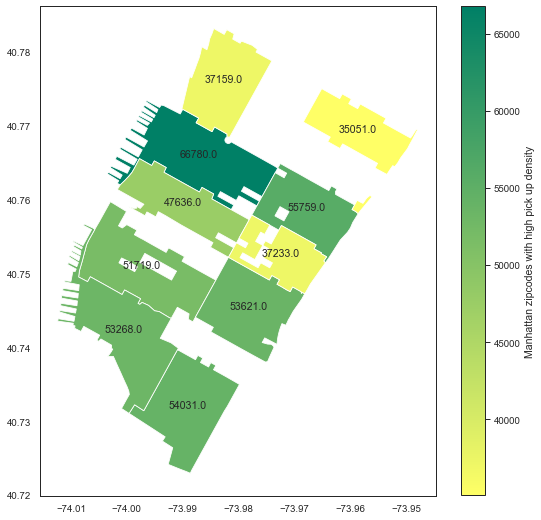

In [145]:

fig, ax = plt.subplots(figsize=(9,9), edgecolor='white',linewidth=2)

#label each zipcode with pickup count
pincodes_manhattan.apply(lambda x: ax.annotate(text=x.zcta_count_p, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

pincodes_manhattan.plot(column='zcta_count_p', 
            ax=ax,
            cmap = 'summer_r',  
            legend=True, 
            legend_kwds={'label': "Manhattan zipcodes with high pick up density", })



### Mapping dur_to_dist - Pickup


<AxesSubplot:>

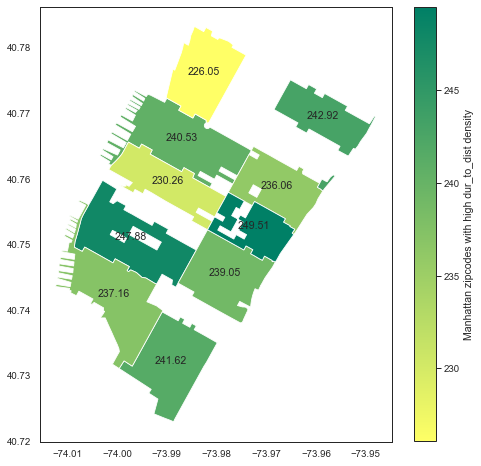

In [143]:
fig, ax = plt.subplots(figsize=(8,8), edgecolor='white',linewidth=4)


#label each zipcode with pickup count
pincodes_manhattan.apply(lambda x: ax.annotate(text=x.dur_to_dist_median_p, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

pincodes_manhattan.plot(column='dur_to_dist_median_p', 
            ax=ax,
            cmap = 'summer_r',  
            legend=True, 
            legend_kwds={'label': "Manhattan zipcodes with high dur_to_dist density"})#'orientation':'horizontal'


## Geographical Mapping - Dropoff Coordinates

### Q2. Which neighborhoods/zip codes tends to experience a relatively higher density of drop-offs?

### Q4. Which neighborhoods/zip codes tends to have the highest duration-to-distance ratios, based on drop-off?

In [75]:
pincodes['zcta_count_d'] = joined_d['zcta'].value_counts()
pincodes['dur_to_dist_median_d'] = joined_d.groupby('zcta')['dur_to_dist_m_spkm'].agg('median').round(2)

In [76]:
print(pincodes.shape)
print(pincodes.head())
print(pincodes.info())

(214, 7)
       bcode                                           geometry  zcta_count_p  \
zcta                                                                            
10001  36061  POLYGON ((-74.00368 40.74835, -74.00653 40.749...       51719.0   
10002  36061  POLYGON ((-73.99695 40.71207, -73.99712 40.712...       19332.0   
10003  36061  POLYGON ((-73.99206 40.72564, -73.99179 40.726...       54031.0   
10007  36061  POLYGON ((-74.01046 40.71153, -74.01015 40.712...        8150.0   
10009  36061  POLYGON ((-73.97521 40.71924, -73.97512 40.719...       19677.0   

       dur_to_dist_median_p  zcta_count_d  dur_to_dist_mean_d  \
zcta                                                            
10001                247.88       51840.0          270.466437   
10002                210.63       17823.0          267.973616   
10003                241.62       44584.0          241.144023   
10007                210.82        6734.0          212.663510   
10009                225.76      

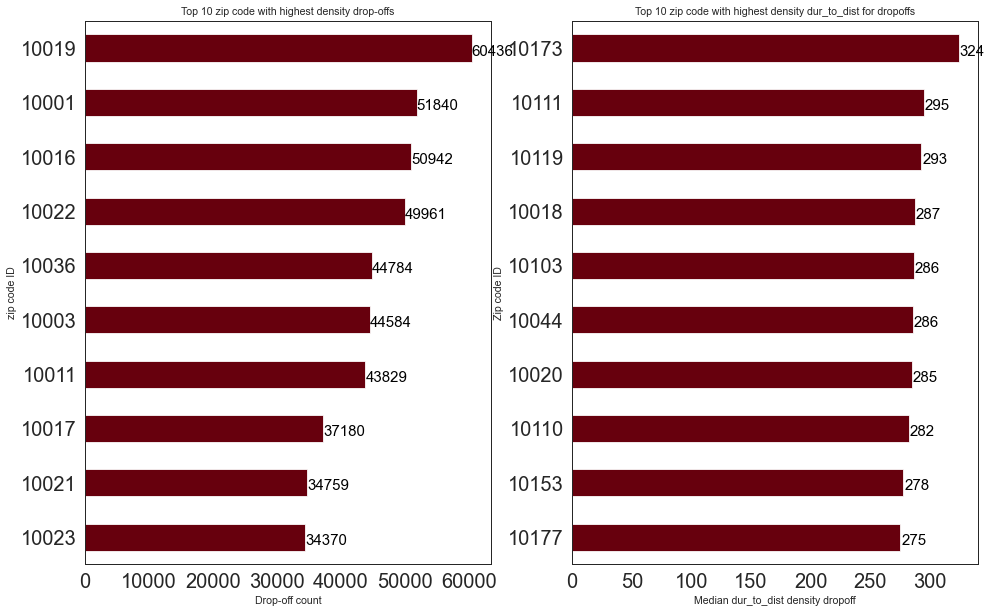

In [119]:
## plotting in subplots. 

fig = plt.figure(figsize=(16,10))

ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

# mapping top 10 zipcodes that have highest density drop-offs


joined_d['zcta'].value_counts().sort_values(ascending=False).head(10).plot.barh(ax=ax1, fontsize=20, cmap='Reds_r')
ax1.set_xlabel('Drop-off count')
ax1.set_ylabel('zip code ID')
ax1.set_title('Top 10 zip code with highest density drop-offs')
ax1.invert_yaxis()

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax1.patches:
    totals.append(i.get_width())

# set individual bar labels using above list
for i in ax1.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax1.text(i.get_width()+0.9, i.get_y()+.38, str(round(i.get_width())), fontsize=15, color='black')
    

# mapping top 10 zipcodes that have highest density drop-offs

joined_d.groupby('zcta')['dur_to_dist_m_spkm'].agg('median').sort_values(ascending=False).head(10).plot.barh(ax=ax2, fontsize=20, cmap='Reds_r')
ax2.set_xlabel('Median dur_to_dist density dropoff')
ax2.set_ylabel('Zip code ID')
ax2.set_title('Top 10 zip code with highest density dur_to_dist for dropoffs')
# invert for largest on top 
ax2.invert_yaxis()

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax2.patches:
    totals.append(i.get_width())

# # set individual bar labels using above list
# total = sum(totals)

# set individual bar labels using above list
for i in ax2.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax2.text(i.get_width()+0.9, i.get_y()+.38, str(round(i.get_width())), fontsize=15, color='black')



<AxesSubplot:>

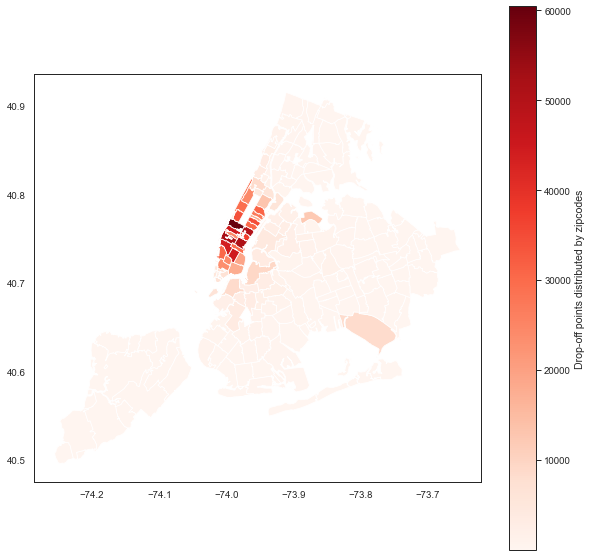

In [120]:
# fig, ax = plt.subplots(1, 1)

fig, ax = plt.subplots(figsize=(10,10), edgecolor='white',linewidth=4)
pincodes.plot(column='zcta_count_d', 
            ax=ax,
            cmap = 'Reds',  
            legend=True, 
            legend_kwds={'label': "Drop-off points distributed by zipcodes"})

### Mapping dur_to_dist - Dropoff


<AxesSubplot:>

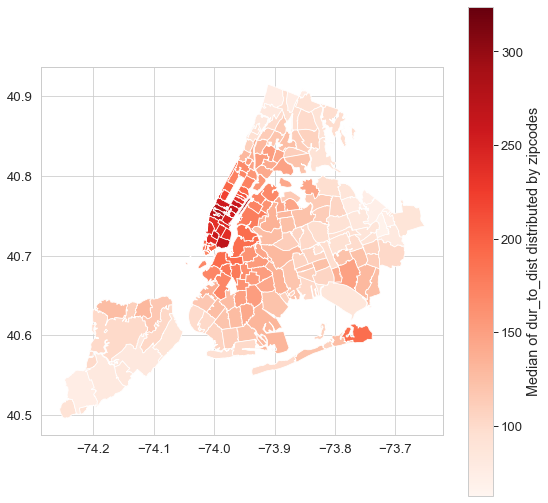

In [92]:

fig, ax = plt.subplots(figsize=(9,9), edgecolor='white',linewidth=2)

#label each zipcode with dur_to_dist_p
# pincodes.apply(lambda x: ax.annotate(text=x.dur_to_dist_mean_d, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)


pincodes.plot(column='dur_to_dist_median_d', 
            ax=ax,
            cmap = 'Reds',  
            legend=True, 
            legend_kwds={'label': "Median of dur_to_dist distributed by zipcodes"})

### Mapping Manhattan borough - Dropoff

In [33]:
# quering the dataset by limiting the output to 'Manhattan' alone with borough code = 36061.

pincodes_manhattan = pincodes.query('bcode == "36061"').sort_values(by='zcta_count_d',ascending=False).head(10)


<AxesSubplot:>

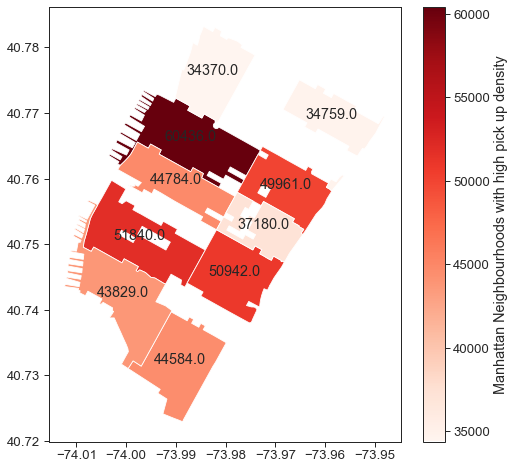

In [34]:

fig, ax = plt.subplots(figsize=(8,8), edgecolor='white',linewidth=2)

#label each zipcode
pincodes_manhattan.apply(lambda x: ax.annotate(text=x.zcta_count_d, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

pincodes_manhattan.plot(column='zcta_count_d', 
            ax=ax,
            cmap = 'Reds',  
            legend=True, 
            legend_kwds={'label': "Manhattan Neighbourhoods with high pick up density"})



In [136]:
# quering the dataset by limiting the output to 'Manhattan' alone with borough code = 36061.

pincodes_manhattan = pincodes.query('bcode == "36061"').sort_values(by='zcta_count_d',ascending=False).head(10)

<AxesSubplot:>

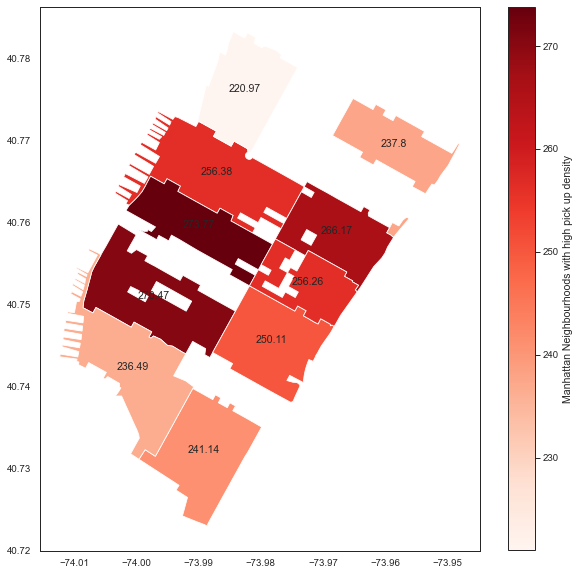

In [142]:
## plotting in subplots. 

fig,ax = plt.subplots(figsize=(10,10))


#label each zipcode
pincodes_manhattan.apply(lambda x: ax.annotate(text=x.dur_to_dist_median_d, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

pincodes_manhattan.plot(column='dur_to_dist_median_d', 
            ax=ax,
            cmap = 'Reds', 
            legend=True, 
            legend_kwds={'label': "Manhattan Neighbourhoods with high pick up density"})



Q5. For any of the neighborhoods identified, are there any potential areas within the neighborhood that are optimal for flying taxi pick-up / drop-off? What makes them suitable?

Answers provided in the presentation with the geographical maps from kepler GIS library.